# Training tree-based algorithms to predict epigenomic-metabolic interactions
**Author**: Scott Campit

# Summary
This notebook trains non-linear machine learning models on metabolomics and proteomics data.

# Load datasets
Now let's load the GCP datasets we'll be computing ratios for. Right now, we'll compute the following ratios:
  * Cancer Cell Line Encyclopedia
  * LeRoy et al., 2012

In [97]:
# Import necessary data science libraries
import pandas as pd
import numpy as np

gcp_path = '~/Data/Proteomics/CCLE/CCLE Global Chromatin Profiles.xlsx'
met_path = '~/Data/Metabolomics/CCLE/ccle_all.json'

GCP = pd.read_excel(gcp_path, 'Single + Ratios')
MET = pd.read_json(met_path)
print(MET.columns.values)
print(GCP)

['Citrate' 'Isocitrate' 'Fumarate' 'NAD' 'NADP' 'Pantothenate' 'PEP'
 'Alanine' 'Valine' 'Leucine' 'Isoleucine' 'Niacinamide'
 '1-methylnicotinamide' '3-phosphoglycerate' 'DHAP' 'Glycine' 'Serine'
 'Methionine' 'Homocysteine' '5-adenosylhomocysteine'
 'Alpha-ketoglutarate' 'Succinate' 'Glutamine' 'Aspartate' 'Glutamate'
 'Cell Lines' 'index' 'Isocitrate/Citrate' 'Fumarate/Citrate'
 'NAD/Citrate' 'NADP/Citrate' 'Pantothenate/Citrate' 'PEP/Citrate'
 'Alanine/Citrate' 'Valine/Citrate' 'Leucine/Citrate' 'Isoleucine/Citrate'
 'Niacinamide/Citrate' '1-methylnicotinamide/Citrate'
 '3-phosphoglycerate/Citrate' 'DHAP/Citrate' 'Glycine/Citrate'
 'Serine/Citrate' 'Methionine/Citrate' 'Homocysteine/Citrate'
 '5-adenosylhomocysteine/Citrate' 'Alpha-ketoglutarate/Citrate'
 'Succinate/Citrate' 'Glutamine/Citrate' 'Aspartate/Citrate'
 'Glutamate/Citrate' 'Citrate/Isocitrate' 'Fumarate/Isocitrate'
 'NAD/Isocitrate' 'NADP/Isocitrate' 'Pantothenate/Isocitrate'
 'PEP/Isocitrate' 'Alanine/Isocitrate' 'Vali

To preprocess the data, we'll do a couple of things, including:
  * Match by cell lines
  * Sort by index
  * Remove unncessary columns
  * Z-score the metabolomics data

In [98]:
idx = list(set(GCP['Cell Lines']) & set(MET['Cell Lines']))
GCP = GCP[GCP['Cell Lines'].isin(idx)]
MET = MET[MET['Cell Lines'].isin(idx)]
GCP = GCP.drop_duplicates(subset='Cell Lines', keep='first')
MET = MET.drop_duplicates(subset='Cell Lines', keep='first')

GCP = GCP.sort_values(by=['Cell Lines'])
MET = MET.sort_values(by=['Cell Lines'])

This code block drops some unnecessary columns in the merged dataset.

In [101]:
cell_lines = GCP['Cell Lines'].values
gcpcol_to_drop = ['Cell Lines'] 
metcol_to_drop = ['index', 'Cell Lines']

GCP = GCP.drop(labels=gcpcol_to_drop, axis=1)
MET = MET.drop(labels=metcol_to_drop, axis=1)

Save the column names, which will be used later when constructing dataframes for evaluating model performance.

In [104]:
metabolites = list(MET.columns)
gcps = list(GCP.columns)
print(len(metabolites))
print(len(gcps))

625
362


Normalize the data if necessary.

In [40]:
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import robust_scale
from scipy.stats import zscore
GCP_norm = GCP
MET_norm = zscore(MET, axis=1)

# SANITY CHECK: Plot the data distributions for the metabolites and histone ratios

<AxesSubplot:ylabel='Density'>

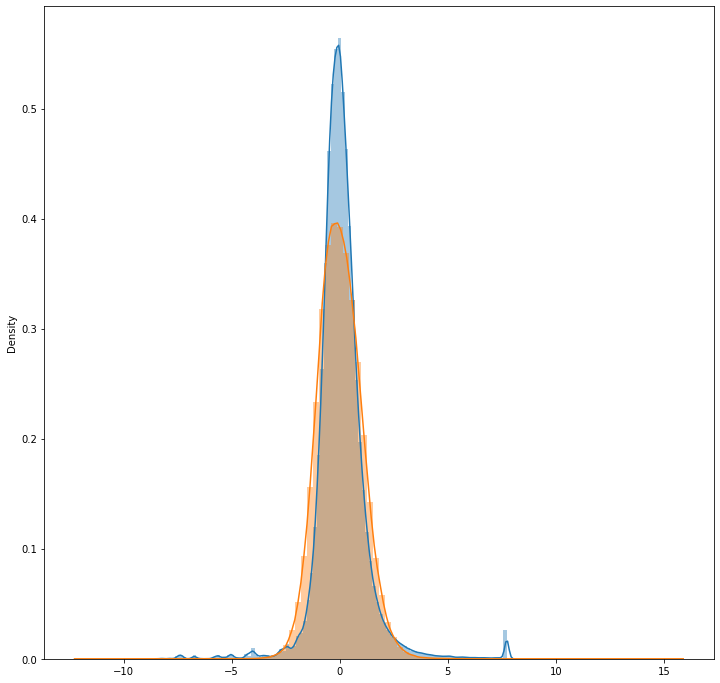

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.figure(figsize=(12, 12))
sns.distplot(GCP, bins=100)
sns.distplot(MET_norm, bins=100)

# Cancer cell line encyclopedia GCP -> Metabolism models
First, let's split the data into training and test sets.

Convert to Numpy array.

In [42]:
GCP_norm = GCP_norm.to_numpy()

Split the data into validation and training data.

In [43]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    GCP_norm, MET_norm, test_size=0.3, random_state=0
)

Print shape of $X_{train}$ and $Y_{train}$.

In [44]:
print(GCP_norm.shape)
print(MET_norm.shape)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(856, 342)
(856, 625)
(599, 342)
(599, 625)
(257, 342)
(257, 625)


In [45]:
print(np.sum(Xtrain == np.inf))
print(np.sum(Xtrain == -np.inf))
print(np.sum(Xtrain == np.NaN))
print(np.sum(Ytrain == np.inf))
print(np.sum(Ytrain == -np.inf))
print(np.sum(Ytrain == np.NaN))

0
0
0
0
0
0


## 3-fold cross validation for non-linear regressor selection
Now let's train a bunch of non-linear regressors and evaluate their performance.

We'll train the following ML models:
  * Random Forests
  * Gradient boosting
  * Gaussian Process Regression
  * XGBoost


In [116]:
# ML models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

# Accessory functions
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from time import sleep
import progressbar

# Suppress annoying warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from joblib import Parallel, delayed, parallel_backend
from skopt import dump, load
from skopt.utils import use_named_args
from sklearn.multioutput import MultiOutputRegressor

import multiprocessing

### Load some hyperparameters to sample

Let's define the search parameters we'll use for hyperparameter optimization

In [122]:
# Gradient boosting
gb_params = {
    'max_depth': Integer(1, 5),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
    'learning_rate': Real(10**-5, 10**0, "log-uniform")
}

# Random Forests
rf_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}

# Extra Trees
et_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
}

# XGBoost
xgb_params ={
    'gamma': Integer(1, 10),
    'learning_rate': Real(10**-5, 0.99, prior="log-uniform"),
    'max_depth': Integer(3, 10),
    'reg_alpha': Real(10**-5, 1, prior="log-uniform"),
    'reg_lambda':Real(10**-5, 1, prior="log-uniform"),
    'max_delta_step': Integer(0, 10),
}

Now let's store our models, hyperparameters, and file paths in a list.

In [123]:
models = [
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          ExtraTreesRegressor(),
          xgb.XGBRegressor()
]
params = [
          rf_params,
          gb_params,
          et_params,
          xgb_params
]
names = [
         '/home/scampit/Data/Models/GCP2Met/rf.pkl',
         '/home/scampit/Data/Models/GCP2Met/gb.pkl',
         '/home/scampit/Data/Models/GCP2Met/et.pkl',
         '/home/scampit/Data/Models/GCP2Met/xgb.pkl'
]

## Specify progress bar and K-folds

Next, we'll specify the parameters for printing out a progress bar, as well as the number and method of kfold splitting.

In [124]:
bar = progressbar.ProgressBar(maxval=Ytrain.shape[1], \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Set the kfold operator to split 3 times with shuffle
kfold = KFold(n_splits=3, 
              shuffle=True, 
              random_state=0)

## Create a function that trains the models

We'll create a function that trains the model and performs the following steps:
  1. Define the BayesOpt object.
  2. Compute a model for each feature.
  3. Save all models based on a designated path.

In [130]:
def train_models(models, params, Xtrain, Ytrain, kfold, filename):
    """
    train_models performs kfold bayesian hyperparameter tuning for different 
    models, and saves the output for model persistence.

    :param models: A single sklearn model object or list of sklearn model objects.
    :param params: A dictionary or list of dictionaries containing hyperparameters 
                 to tune.
    :param Xtrain: A numpy array or pandas dataframe containing the training data.
    :param Ytrain: A numpy array or pandas dataframe containing the output data.
    :param kfold:  An integer or sklearn object determining the kfold operation 
                 performed.
    :param filename: A string or list of paths to save the models (pickle).

    """
    no_of_cpus = multiprocessing.cpu_count()

    with parallel_backend('threading', n_jobs=no_of_cpus):
        for i in range(len(models)):
            opt = BayesSearchCV(
                                  estimator=models[i],
                                  search_spaces=params[i],
                                  n_iter=30,
                                  cv=kfold,
                                  n_jobs=-1,
                                  random_state=0
            )

            mdls =[]
            bar.start()
            for j in range(Ytrain.shape[1]):
                _ = opt.fit(Xtrain, Ytrain[:, j])
                mdls.append(opt)
                dump(res=mdls, filename=filename[i])
                bar.update(j)
                sleep(0.1)
            print("Finished hyperparameter optimization and cross validation for model number: " 
                          + str(i))

Now train the models.

In [ ]:
train_models(models, params, Xtrain, Ytrain, kfold, names)

/home/scampit/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/scampit/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/scampit/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/scampit/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/scampit/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

# Cancer cell line encyclopedia Metabolism -> GCP models
Now we'll try to learn models that do the reverse problem: predicting chromatin profiles using metabolic data. 

In [58]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    MET_norm, GCP_norm, test_size=0.3, random_state=0
)
names = [
         '/home/scampit/Data/Models/Met2GCP/rf.pkl',
         '/home/scampit/Data/Models/Met2GCP/gb.pkl',
         '/home/scampit/Data/Models/Met2GCP/et.pkl',
         '/home/scampit/Data/Models/Met2GCP/xgb.pkl'
]

Finally, let's train the models.

In [120]:
train_models(models, params, Xtrain, Ytrain, kfold, names)

ValueError: Invalid parameter max_depth for estimator MultiOutputRegressor(estimator=RandomForestRegressor()). Check the list of available parameters with `estimator.get_params().keys()`.

In [129]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# Evaluating the models

## GCP to MET models
Now that I have some models trained up, it's time to create some data structures that will have the metrics I want. First, let's grab the validatoin set again from the `train_test_split()` function. Because the seed is set, it should get me the same entries.

In [63]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    GCP_norm, MET_norm, test_size=0.3, random_state=0
)

Next, we'll load some libraries we'll be using to evaluate the predicted value against the true value.

In [64]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Let's now load the models we have trained to predict metabolite values from chromatin profiles.

In [65]:
mdls = [load('/home/scampit/Data/Models/GCP2Met/rf.pkl'),
        load('/home/scampit/Data/Models/GCP2Met/gb.pkl'),
        load('/home/scampit/Data/Models/GCP2Met/et.pkl'),
        load('/home/scampit/Data/Models/GCP2Met/xgb.pkl')
]

The `evaluate_models()` function will compute evaluation metrics and spit out the final metrics of interest.

In [82]:
def evaluate_models(models, Xval, Yval):
    """
    evaluate_models returns metrics from the model predictions, include the pearson
    correlation coefficient, coefficient of determination, MSE, and MAE.

    :param models:         A scikit-learn model object or list of model objects.
    :param Xval:           A numpy array or pandas dataframe containing 
                         validation set input data.
    :param Yval:           A numpy array or pandas dataframe containing 
                         validation set output data.
    :return final_metrics: A pandas dataframe or list of dfs containing the final 
                         evaluation metrics
    """

    final_metrics = []
    for j in range(len(models)):
        # Iterate through model objects
        m = models[j]

        r_values = list()
        p_values = list()
        mse_values = list()
        mae_values = list()

        # Iterate through features
        for i in range(len(m)):
            mdl = m[i]
            ypred = mdl.predict(Xval)
            r, pvalue = pearsonr(ypred, Yval[:, i])
            mse = mean_squared_error(ypred, Yval[:, i])
            mae = mean_absolute_error(ypred, Yval[:, i])

            r_values.append(r)
            p_values.append(pvalue)
            mae_values.append(mae)
            mse_values.append(mse)

        # Save the metrics in a dataframe
        pre_df = {
                  "Pearson": r_values, 
                  "Pvalue":  p_values,
                  "MSE":     mse_values,
                  "MAE":     mae_values
                  }
        df = pd.DataFrame(pre_df)
        final_metrics.append(df)

    return final_metrics

Let's run the function on the list of regressors I have trained. Then we'll perform the following operations:

  1. Concatenate the results into a single dataframe
  2. Append the metabolite names to the list
  3. Sort the values in ascending alphabetical order by metabolite name
  4. Save the final results to the Google Sheet.

In [83]:
final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["Metabolites"] = metabolites
final_metrics = final_metrics.sort_values(by="Metabolites", 
                                          ascending=True)

path = '/home/scampit/Data/Models/GCP2Met/gcp2met_metrics.csv'
final_metrics.to_csv(path)

In [78]:
print(final_metrics["Metabolites"])

0                               Citrate
1                            Isocitrate
2                              Fumarate
3                                   NAD
4                                  NADP
                     ...               
620    5-adenosylhomocysteine/Glutamate
621       Alpha-ketoglutarate/Glutamate
622                 Succinate/Glutamate
623                 Glutamine/Glutamate
624                 Aspartate/Glutamate
Name: Metabolites, Length: 625, dtype: object


## MET to GCP models
Now let's do the reverse using the same operations described above.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    MET_norm, GCP_norm, test_size=0.3, random_state=0
)

mdls = [load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/rf.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/gb.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/et.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/xgb.pkl')
]

final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["GCP"] = gcps
final_metrics = final_metrics.sort_values(by=["GCP"], 
                                          axis=1, 
                                          ascending=True)

url = 'https://docs.google.com/spreadsheets/d/1_tFjeBplSfozCw0VIU84j8d0NTm4CyOAFr9tXQfBLoE/edit?usp=sharing'
sheetname = 'Met2GCP_Ratios_Nonlinear'

save_gsheet(final_metrics, url, sheetname)